<a href="https://colab.research.google.com/github/hanaamirahn/Skripsi_Stunting/blob/main/skripsi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install dependencies
!pip install -q pyswarms imbalanced-learn

# **Import Library & Config**

In [ ]:
import warnings, time, os
warnings.filterwarnings('ignore')

#Data manipulasi dan visualisasi data
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing & split data
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

#Train dan test library
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

#Ketidakseimbangan data SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

#Optimasi PSO
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx

#Evaluasi Metriks
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

#Other
from sklearn.impute import SimpleImputer
import joblib

In [ ]:
# Repro
# Konfigurasi global
RANDOM_STATE = 42
TEST_SIZE = 0.2
CV_FOLDS = 4  # cross-val folds for PSO
PSO_PARTICLES = 20
PSO_ITERS = 20

# **Data Wrangling**

**Gathering Data**

In [ ]:
data = pd.read_csv("/content/Stunting_Dataset.csv")
print(data.shape)
print(data)

(10000, 8)
      Gender  Age  Birth Weight  Birth Length  Body Weight  Body Length  \
0       Male   17           3.0            49         10.0         72.2   
1     Female   11           2.9            49          2.9         65.0   
2       Male   16           2.9            49          8.5         72.2   
3       Male   31           2.8            49          6.4         63.0   
4       Male   15           3.1            49         10.5         49.0   
...      ...  ...           ...           ...          ...          ...   
9995    Male   15           3.0            49          9.0         63.0   
9996  Female   12           2.8            48          7.7         63.0   
9997    Male   16           2.8            49          7.7         49.0   
9998    Male   14           2.8            49         10.0         69.0   
9999  Female   10           3.0            49          7.7         80.0   

     Breastfeeding Stunting  
0               No       No  
1               No      Yes 

In [ ]:
# Menghapus kolom yang tidak diperlukan
data = data.drop(columns=['Breastfeeding'])
print(data)

      Gender  Age  Birth Weight  Birth Length  Body Weight  Body Length  \
0       Male   17           3.0            49         10.0         72.2   
1     Female   11           2.9            49          2.9         65.0   
2       Male   16           2.9            49          8.5         72.2   
3       Male   31           2.8            49          6.4         63.0   
4       Male   15           3.1            49         10.5         49.0   
...      ...  ...           ...           ...          ...          ...   
9995    Male   15           3.0            49          9.0         63.0   
9996  Female   12           2.8            48          7.7         63.0   
9997    Male   16           2.8            49          7.7         49.0   
9998    Male   14           2.8            49         10.0         69.0   
9999  Female   10           3.0            49          7.7         80.0   

     Stunting  
0          No  
1         Yes  
2         Yes  
3         Yes  
4         Yes  
...

**Assessing Data**

In [ ]:
# Menampilkan informasi pada dataset
print("=== SHAPE DATA ===")
print(data.shape)

print("\n=== 5 BARIS PERTAMA ===")
display(data.head())

print("\n=== INFORMASI DATA ===")
display(data.info())

=== SHAPE DATA ===
(10000, 7)

=== 5 BARIS PERTAMA ===


,Gender,Age,Birth Weight,Birth Length,Body Weight,Body Length,Stunting
0,Male,17,3.0,49,10.0,72.2,No
1,Female,11,2.9,49,2.9,65.0,Yes
2,Male,16,2.9,49,8.5,72.2,Yes
3,Male,31,2.8,49,6.4,63.0,Yes
4,Male,15,3.1,49,10.5,49.0,Yes



=== INFORMASI DATA ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Gender        10000 non-null  object 
 1   Age           10000 non-null  int64  
 2   Birth Weight  10000 non-null  float64
 3   Birth Length  10000 non-null  int64  
 4   Body Weight   10000 non-null  float64
 5   Body Length   10000 non-null  float64
 6   Stunting      10000 non-null  object 
dtypes: float64(3), int64(2), object(2)
memory usage: 547.0+ KB


None

In [ ]:
# Memeriksa missing value
data.isna().sum()

,0
Gender,0
Age,0
Birth Weight,0
Birth Length,0
Body Weight,0
Body Length,0
Stunting,0


In [ ]:
# Memeriksa duplikasi data
print("Jumlah duplikasi: ", data.duplicated().sum())

Jumlah duplikasi:  2427


In [ ]:
data[data.duplicated(keep=False)].head(10)

,Gender,Age,Birth Weight,Birth Length,Body Weight,Body Length,Stunting
5,Female,11,2.8,49,8.5,65.0,No
9,Female,16,2.8,49,8.5,65.0,Yes
11,Male,13,2.9,50,10.0,69.0,Yes
15,Female,13,2.8,49,10.5,72.2,Yes
16,Male,7,2.3,50,6.4,68.3,No
19,Female,13,3.1,49,7.0,65.0,Yes
21,Male,17,2.9,49,9.0,69.0,Yes
22,Male,13,2.9,49,9.0,69.0,Yes
23,Male,7,2.3,50,6.4,63.0,No
26,Female,15,2.8,49,8.5,65.0,Yes


In [ ]:
#Deteksi Kolom Target
print("\n=== DETEKSI KOLOM TARGET ===")
TARGET_COL = None
possible_targets = ['stunting', 'Stunting', 'stunted', 'Stunted', 'label', 'Label', 'target', 'Target']

for col in possible_targets:
    if col in data.columns:
        TARGET_COL = col
        break

# fallback: anggap kolom terakhir adalah target
if TARGET_COL is None:
    TARGET_COL = data.columns[-1]

print(f"Kolom target terdeteksi: {TARGET_COL}")


=== DETEKSI KOLOM TARGET ===
Kolom target terdeteksi: Stunting


In [ ]:
# Identifikasi kolom numerik & kategorikal (tidak termasuk target)
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
if TARGET_COL in num_cols:
    num_cols.remove(TARGET_COL)

cat_cols = [c for c in data.columns if c not in num_cols + [TARGET_COL]]

print("\nFitur numerik:", num_cols)
print("Fitur kategorikal:", cat_cols)

print("\n=== DETEKSI KOLOM OBJEK YANG MUNGKIN SEHARUSNYA NUMERIK ===")
maybe_numeric = []
obj_cols = data.select_dtypes(include=['object']).columns.tolist()

for c in obj_cols:
    # Coba paksa casting
    coerced = pd.to_numeric(data[c], errors='coerce')
    # Jika >70% nilai dapat dikonversi → kemungkinan fitur numerik salah format
    if coerced.notna().mean() > 0.7:
        maybe_numeric.append(c)

if maybe_numeric:
    print("Kolom object yang tampak numerik:", maybe_numeric)
else:
    print("Tidak ada kolom object yang tampak numerik.")



Fitur numerik: ['Age', 'Birth Weight', 'Birth Length', 'Body Weight', 'Body Length']
Fitur kategorikal: ['Gender']

=== DETEKSI KOLOM OBJEK YANG MUNGKIN SEHARUSNYA NUMERIK ===
Tidak ada kolom object yang tampak numerik.


In [ ]:
# Simpan ringkasan cepat (opsional)
summary = {
    'n_rows': data.shape[0],
    'n_cols': data.shape[1],
    'n_duplicates': int(dup),
    'missing_total_percent': float(data.isna().mean().mean() * 100),
    'target_col': TARGET_COL
}
pd.DataFrame([summary]).T.to_csv("summary_assessing.csv")

print("\n=== SUMMARY ASSESSING ===")
print(summary)
print("\nRingkasan assessing disimpan ke summary_assessing.csv")

NameError: name 'dup' is not defined

**Cleaning Data**

In [ ]:
TARGET_COL_RAW = 'Stunting'
CAT_COLS = ['Gender']
NUM_COLS = ['Age', 'Birth Weight', 'Birth Length', 'Body Weight', 'Body Length']

In [ ]:
#NORMALISASI LABEL TARGET
print("\nUnique values pada kolom Stunting (sebelum normalisasi):")
print(data[TARGET_COL_RAW].unique())

data[TARGET_COL_RAW] = (
    data[TARGET_COL_RAW]
    .astype(str)
    .str.strip()
    .str.upper()
    .replace({'YA':'YES', 'TIDAK':'NO', 'Y':'YES', 'N':'NO'})
)

print("\nUnique values kolom Stunting (setelah normalisasi):")
print(data[TARGET_COL_RAW].unique())


Unique values pada kolom Stunting (sebelum normalisasi):
['No' 'Yes']

Unique values kolom Stunting (setelah normalisasi):
['NO' 'YES']


# **Exploratory Data Analysis**

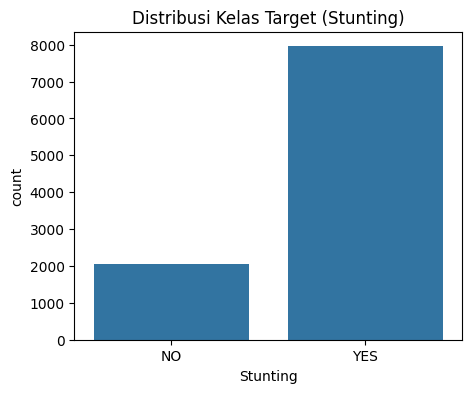

Stunting
YES    7955
NO     2045
Name: count, dtype: int64

Proporsi:
 Stunting
YES    0.7955
NO     0.2045
Name: proportion, dtype: float64


In [ ]:
#Distribusi kelas target
plt.figure(figsize=(5,4))
sns.countplot(data=data, x=TARGET_COL_RAW)
plt.title("Distribusi Kelas Target (Stunting)")
plt.show()

print(data[TARGET_COL_RAW].value_counts())
print("\nProporsi:\n", data[TARGET_COL_RAW].value_counts(normalize=True))

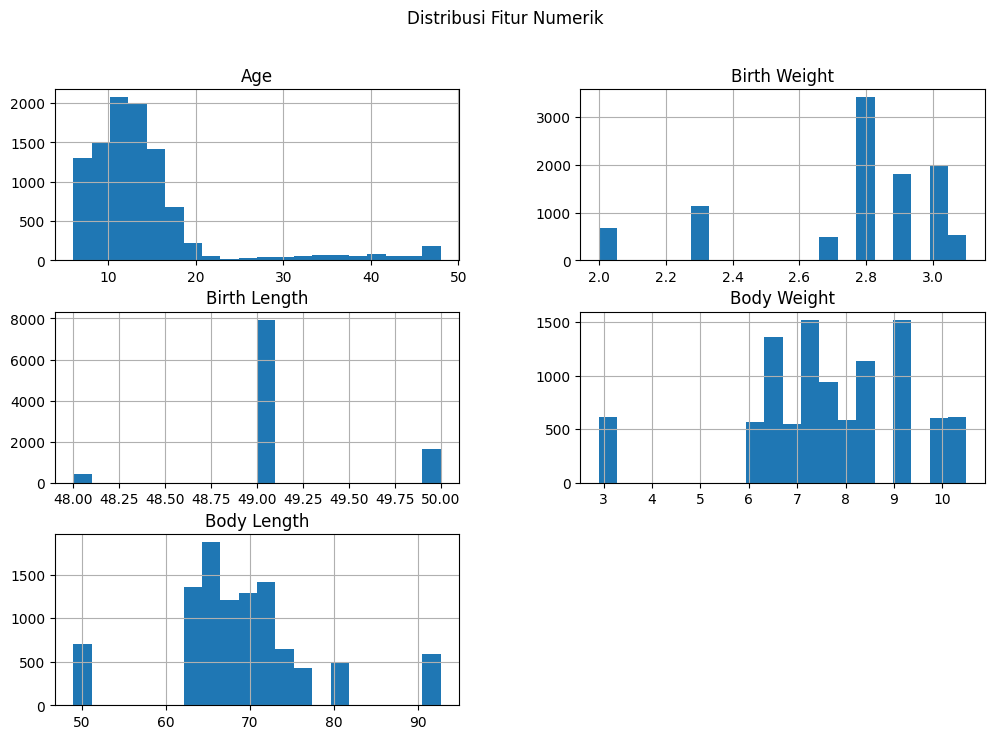

In [ ]:
#Distribusi fitur numerik
data[NUM_COLS].hist(figsize=(12,8), bins=20)
plt.suptitle("Distribusi Fitur Numerik")
plt.show()

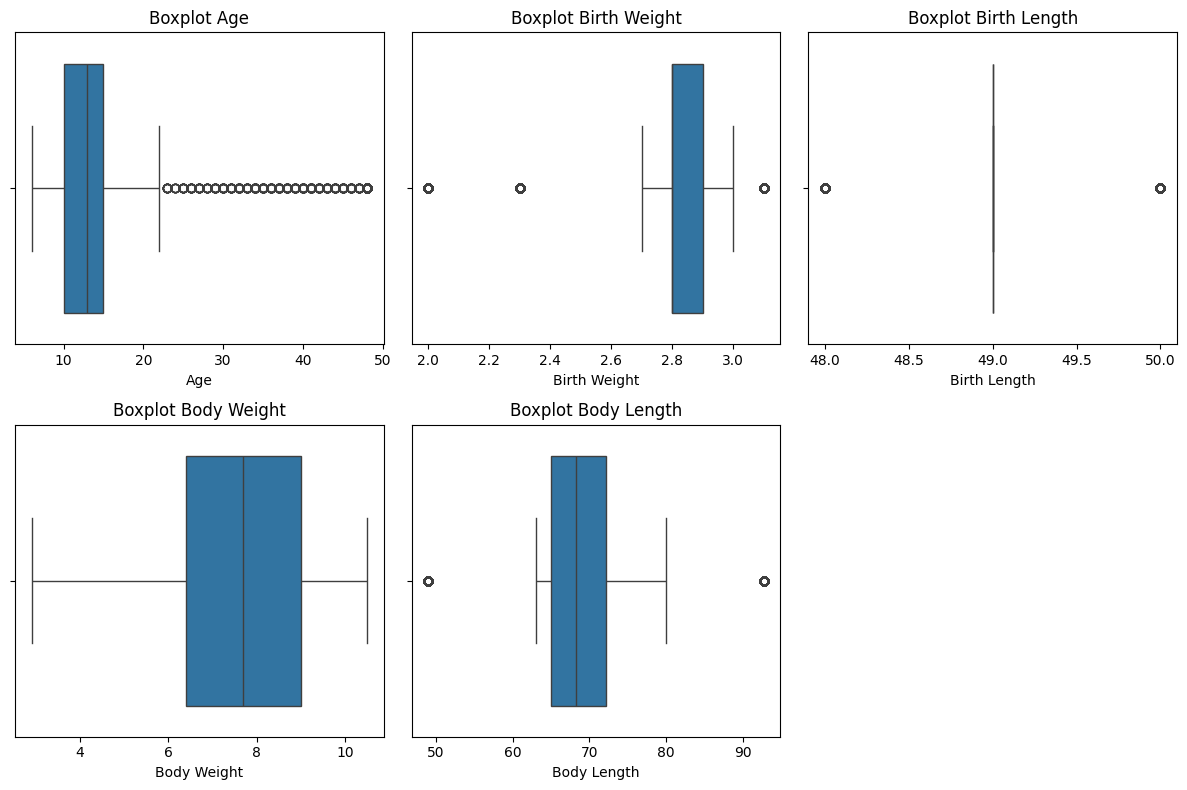

In [ ]:
#Distribusi fitur per kelas target
plt.figure(figsize=(12,8))
for i, col in enumerate(NUM_COLS, 1):
    plt.subplot(2,3,i)
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot {col}")
plt.tight_layout()
plt.show()

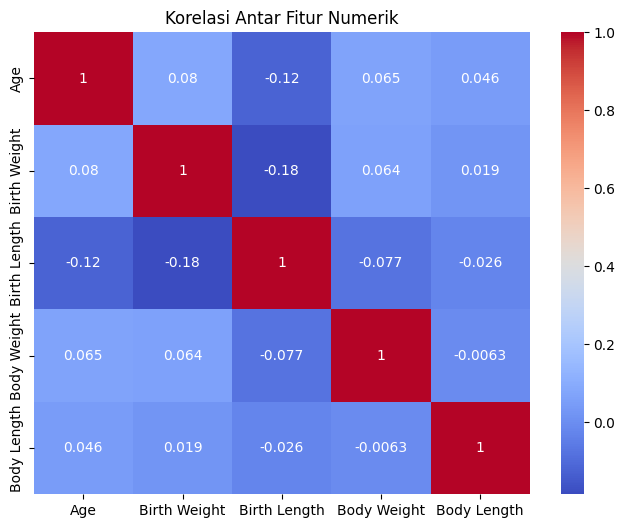

In [ ]:
#Korelasi antar fitur numerik
plt.figure(figsize=(8,6))
sns.heatmap(data[NUM_COLS].corr(), annot=True, cmap="coolwarm")
plt.title("Korelasi Antar Fitur Numerik")
plt.show()

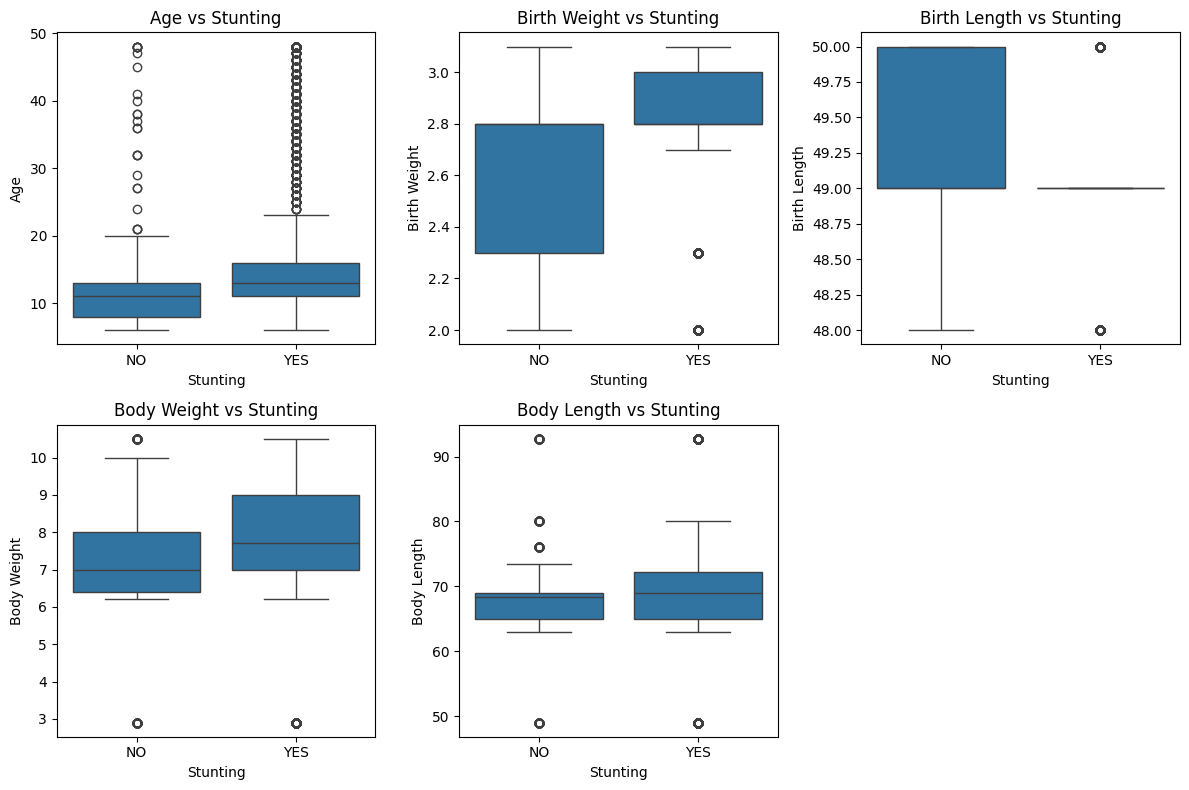

In [ ]:
#fitur numerik vs target
plt.figure(figsize=(12,8))
for i, col in enumerate(NUM_COLS, 1):
    plt.subplot(2,3,i)
    sns.boxplot(data=data, x=TARGET_COL_RAW, y=col)
    plt.title(f"{col} vs Stunting")
plt.tight_layout()
plt.show()


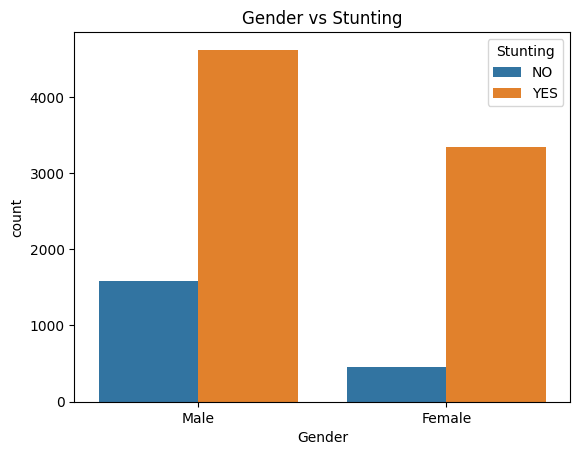

In [ ]:
#fitur kategorikal vs target
sns.countplot(data=data, x="Gender", hue=TARGET_COL_RAW)
plt.title("Gender vs Stunting")
plt.show()

# **Encoding & Scaling**

In [ ]:
# Salin data asli
df = data.copy()

# 1. ENCODING TARGET
# ==============================
target_le = LabelEncoder()
df['Stunting'] = target_le.fit_transform(df['Stunting'])

print("Mapping Target:")
print(dict(zip(target_le.classes_, target_le.transform(target_le.classes_))))

# ==============================
# 2. ENCODING GENDER
# ==============================
gender_le = LabelEncoder()
df['Gender'] = gender_le.fit_transform(df['Gender'])

print("\nMapping Gender:")
print(dict(zip(gender_le.classes_, gender_le.transform(gender_le.classes_))))

# ==============================
# 3. SCALING NUMERIK
# ==============================
NUM_COLS = ['Age', 'Birth Weight', 'Birth Length', 'Body Weight', 'Body Length']
scaler = StandardScaler()
df[NUM_COLS] = scaler.fit_transform(df[NUM_COLS])

print("\n=== Preview Setelah Encoding + Scaling ===")
print(df.head())

Mapping Target:
{'NO': np.int64(0), 'YES': np.int64(1)}

Mapping Gender:
{'Female': np.int64(0), 'Male': np.int64(1)}

=== Preview Setelah Encoding + Scaling ===
   Gender       Age  Birth Weight  Birth Length  Body Weight  Body Length  \
0       1  0.346465      0.832767     -0.266944     1.376450     0.375590   
1       0 -0.410835      0.489216     -0.266944    -2.750558    -0.432836   
2       1  0.220248      0.489216     -0.266944     0.504547     0.375590   
3       1  2.113497      0.145666     -0.266944    -0.716117    -0.657399   
4       1  0.094031      1.176318     -0.266944     1.667084    -2.229338   

   Stunting  
0         0  
1         1  
2         1  
3         1  
4         1  


# **Split Data (Train/Test)**

In [ ]:
# Pisahkan fitur dan target
X = df.drop(columns=['Stunting'])
y = df['Stunting']

# Split data dengan stratifikasi
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# ===============================
# JUMLAH DATA
# ===============================
print("=== Jumlah Data ===")
print(f"Total data        : {len(df)}")
print(f"X_train           : {X_train.shape}")
print(f"y_train           : {y_train.shape}")
print(f"X_test            : {X_test.shape}")
print(f"y_test            : {y_test.shape}")

# ===============================
# DISTRIBUSI KELAS TARGET
# ===============================
print("\n=== Distribusi Kelas Target ===")

print("\nData Target (Keseluruhan):")
print(y.value_counts().rename(index={0: "0 (NO)", 1: "1 (YES)"}))

print("\ny_train:")
print(y_train.value_counts().rename(index={0: "0 (NO)", 1: "1 (YES)"}))

print("\ny_test:")
print(y_test.value_counts().rename(index={0: "0 (NO)", 1: "1 (YES)"}))

=== Jumlah Data ===
Total data        : 10000
X_train           : (8000, 6)
y_train           : (8000,)
X_test            : (2000, 6)
y_test            : (2000,)

=== Distribusi Kelas Target ===

Data Target (Keseluruhan):
Stunting
1 (YES)    7955
0 (NO)     2045
Name: count, dtype: int64

y_train:
Stunting
1 (YES)    6364
0 (NO)     1636
Name: count, dtype: int64

y_test:
Stunting
1 (YES)    1591
0 (NO)      409
Name: count, dtype: int64


# **SMOTE**

In [ ]:
# Salin dulu train set untuk skenario 1 (tanpa SMOTE)
X_train_ori = X_train.copy()
y_train_ori = y_train.copy()

# =======================
#  SMOTE untuk skenario 2 & 3
# =======================
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\n=== Distribusi Sebelum SMOTE ===")
print(y_train.value_counts())

print("\n=== Distribusi Setelah SMOTE ===")
print(y_train_smote.value_counts())



=== Distribusi Sebelum SMOTE ===
Stunting
1    6364
0    1636
Name: count, dtype: int64

=== Distribusi Setelah SMOTE ===
Stunting
1    6364
0    6364
Name: count, dtype: int64


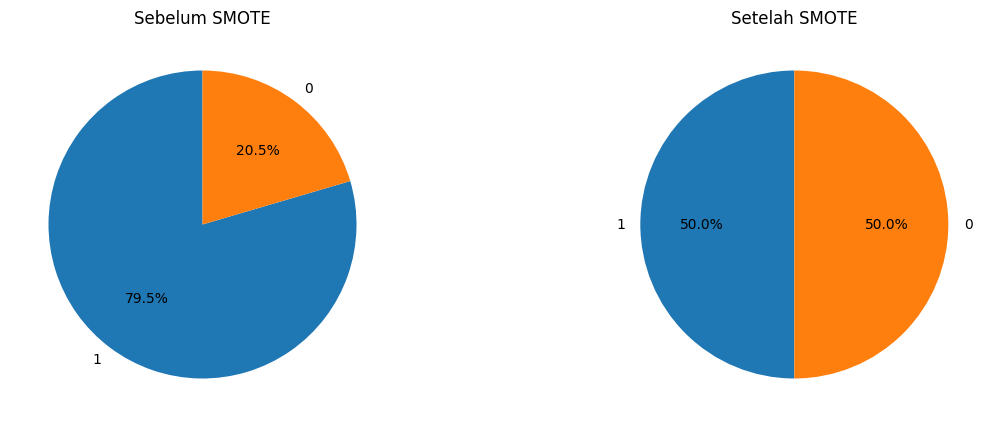

In [ ]:
# Visualisasi Distribusi Kelas Sebelum & Sesudah SMOTE
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Pie sebelum SMOTE
ax[0].pie(y_train.value_counts(), labels=y_train.value_counts().index,
          autopct='%1.1f%%', startangle=90)
ax[0].set_title("Sebelum SMOTE")

# Pie sesudah SMOTE
ax[1].pie(y_train_smote.value_counts(), labels=y_train_smote.value_counts().index,
          autopct='%1.1f%%', startangle=90)
ax[1].set_title("Setelah SMOTE")

plt.show()


# **SKENARIO PEMODELAN**

**RF Only**


=== SKENARIO 1: Random Forest ORI (No SMOTE, No PSO) ===

=== Hasil Evaluasi (Skenario 1) ===
Akurasi   : 0.8415
Presisi   : 0.8769
Recall    : 0.9315
F1-Score  : 0.9034

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.65      0.49      0.56       409
           1       0.88      0.93      0.90      1591

    accuracy                           0.84      2000
   macro avg       0.76      0.71      0.73      2000
weighted avg       0.83      0.84      0.83      2000



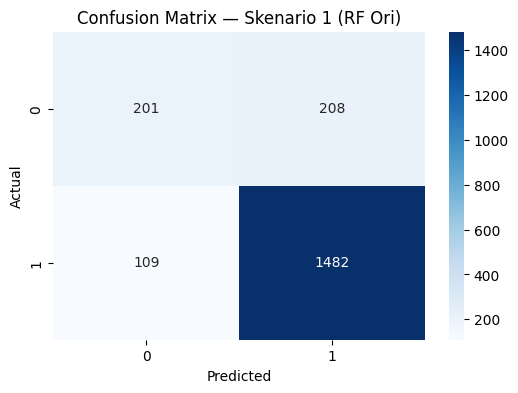

In [ ]:
print("\n=== SKENARIO 1: Random Forest ORI (No SMOTE, No PSO) ===")

# Model RF dengan parameter default sklearn
rf_ori = RandomForestClassifier(random_state=42)

# Training model
rf_ori.fit(X_train_ori, y_train_ori)

# Prediksi
y_pred_ori = rf_ori.predict(X_test)

# Evaluasi
acc_ori  = accuracy_score(y_test, y_pred_ori)
prec_ori = precision_score(y_test, y_pred_ori)
rec_ori  = recall_score(y_test, y_pred_ori)
f1_ori   = f1_score(y_test, y_pred_ori)

print("\n=== Hasil Evaluasi (Skenario 1) ===")
print(f"Akurasi   : {acc_ori:.4f}")
print(f"Presisi   : {prec_ori:.4f}")
print(f"Recall    : {rec_ori:.4f}")
print(f"F1-Score  : {f1_ori:.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred_ori))

# 5. Confusion Matrix
cm_ori = confusion_matrix(y_test, y_pred_ori)

plt.figure(figsize=(6,4))
sns.heatmap(cm_ori, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix — Skenario 1 (RF Ori)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**RF + SMOTE**


=== SKENARIO 2: Random Forest + SMOTE (Default Params) ===

=== Hasil Evaluasi (Skenario 2) ===
Akurasi   : 0.8290
Presisi   : 0.8815
Recall    : 0.9070
F1-Score  : 0.8941

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.59      0.53      0.56       409
           1       0.88      0.91      0.89      1591

    accuracy                           0.83      2000
   macro avg       0.74      0.72      0.73      2000
weighted avg       0.82      0.83      0.83      2000



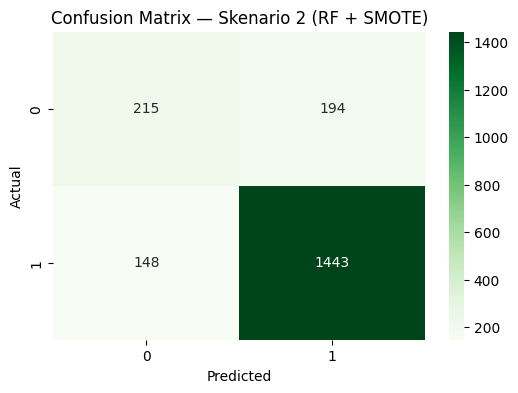

In [ ]:
print("\n=== SKENARIO 2: Random Forest + SMOTE (Default Params) ===")

# Model Random Forest (default)
rf_smote = RandomForestClassifier(random_state=42)

# Train model menggunakan data SMOTE
rf_smote.fit(X_train_smote, y_train_smote)

# Prediksi
y_pred_smote = rf_smote.predict(X_test)

# Evaluasi
acc_smote  = accuracy_score(y_test, y_pred_smote)
prec_smote = precision_score(y_test, y_pred_smote)
rec_smote  = recall_score(y_test, y_pred_smote)
f1_smote   = f1_score(y_test, y_pred_smote)

print("\n=== Hasil Evaluasi (Skenario 2) ===")
print(f"Akurasi   : {acc_smote:.4f}")
print(f"Presisi   : {prec_smote:.4f}")
print(f"Recall    : {rec_smote:.4f}")
print(f"F1-Score  : {f1_smote:.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred_smote))

# Confusion Matrix
cm_smote = confusion_matrix(y_test, y_pred_smote)

plt.figure(figsize=(6,4))
sns.heatmap(cm_smote, annot=True, cmap="Greens", fmt="d")
plt.title("Confusion Matrix — Skenario 2 (RF + SMOTE)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**RF + SMOTE + PSO**

In [ ]:
#  1. Definisikan fungsi fitness untuk PSO
# =======================
def rf_fitness(params):
    # params: array 2D, tiap baris = [n_estimators, max_depth, min_samples_split, min_samples_leaf]
    scores = []

    for param in params:
        # Pastikan integer
        n_estimators   = int(param[0])
        max_depth      = int(param[1])
        min_samples_split = int(param[2])
        min_samples_leaf  = int(param[3])

        # Build model
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )

        # Cross-Validation 3-fold
        cv_scores = cross_val_score(model, X_train_smote, y_train_smote, cv=3, scoring='f1')
        scores.append(1 - cv_scores.mean())  # PSO minimisasi -> gunakan 1-F1

    return np.array(scores)

# =======================
#  2. Tentukan batasan parameter untuk PSO
# =======================
# format: [n_estimators, max_depth, min_samples_split, min_samples_leaf]
bounds = (
    [50, 2, 2, 2],   # lower bounds
    [300, 50, 5, 20] # upper bounds
)

# =======================
#  3. Inisialisasi PSO
# =======================
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}  # parameter PSO

optimizer = ps.single.GlobalBestPSO(
    n_particles=10,  # jumlah partikel
    dimensions=4,    # jumlah hyperparameter
    options=options,
    bounds=bounds
)

# =======================
#  4. Jalankan optimasi PSO
# =======================
best_cost, best_pos = optimizer.optimize(rf_fitness, iters=50)

# Ambil parameter terbaik dan ubah ke integer
best_params = {
    'n_estimators': int(best_pos[0]),
    'max_depth': int(best_pos[1]),
    'min_samples_split': int(best_pos[2]),
    'min_samples_leaf': int(best_pos[3]),
    'random_state': 42
}

print("\n=== Parameter Terbaik Hasil PSO ===")
print(best_params)

2025-12-28 09:06:08,338 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.108
2025-12-28 09:55:37,020 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.10764508636864434, best pos: [214.28807323  22.18924359   2.66312518   2.51778396]



=== Parameter Terbaik Hasil PSO ===
{'n_estimators': 214, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 2, 'random_state': 42}



=== Hasil Evaluasi (Skenario 3) ===
Akurasi   : 0.8475
Presisi   : 0.8855
Recall    : 0.9283
F1-Score  : 0.9064

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.66      0.53      0.59       409
           1       0.89      0.93      0.91      1591

    accuracy                           0.85      2000
   macro avg       0.77      0.73      0.75      2000
weighted avg       0.84      0.85      0.84      2000



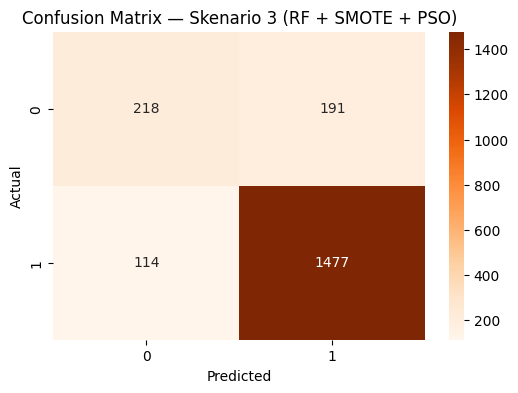

In [ ]:
rf_pso = RandomForestClassifier(**best_params)
rf_pso.fit(X_train_smote, y_train_smote)

# =======================
#  Evaluasi pada data test
# =======================
y_pred_pso = rf_pso.predict(X_test)

acc_pso  = accuracy_score(y_test, y_pred_pso)
prec_pso = precision_score(y_test, y_pred_pso)
rec_pso  = recall_score(y_test, y_pred_pso)
f1_pso   = f1_score(y_test, y_pred_pso)

print("\n=== Hasil Evaluasi (Skenario 3) ===")
print(f"Akurasi   : {acc_pso:.4f}")
print(f"Presisi   : {prec_pso:.4f}")
print(f"Recall    : {rec_pso:.4f}")
print(f"F1-Score  : {f1_pso:.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred_pso))

# =======================
#  Confusion Matrix
# =======================
cm_pso = confusion_matrix(y_test, y_pred_pso)

plt.figure(figsize=(6,4))
sns.heatmap(cm_pso, annot=True, cmap="Oranges", fmt="d")
plt.title("Confusion Matrix — Skenario 3 (RF + SMOTE + PSO)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# ===============================
#   MODEL EVALUATION UNIVERSAL
# ===============================

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)
import pandas as pd

def evaluate_model(name, y_true, y_pred):
    """Evaluasi standar untuk setiap skenario"""
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n=== {name} ===")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall    : {rec:.4f}")
    print(f"F1-score  : {f1:.4f}")
    print("\n--- Classification Report ---")
    print(classification_report(y_true, y_pred))
    print("\nConfusion Matrix:")
    print(cm)

    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    }


# ===============================
#      EVALUASI 3 SKENARIO
# ===============================

results = []
results.append(evaluate_model("RF Original", y_test, y_pred_ori))
results.append(evaluate_model("RF + SMOTE", y_test, y_pred_smote))
results.append(evaluate_model("RF + SMOTE + PSO", y_test, y_pred_pso))


# ===============================
#        ANALISIS TAMBAHAN
# ===============================

print("\n============================")
print("ANALISIS TAMBAHAN")
print("============================")

# 1. Efek SMOTE terhadap Recall
print("\n➡ Efek SMOTE terhadap Recall:")
rec_ori = recall_score(y_test, y_pred_ori)
rec_smote = recall_score(y_test, y_pred_smote)

print(f"Recall sebelum SMOTE : {rec_ori:.4f}")
print(f"Recall sesudah SMOTE : {rec_smote:.4f}")

if rec_smote > rec_ori:
    print("✔ Recall meningkat setelah SMOTE.")
else:
    print("✘ Recall tidak meningkat setelah SMOTE.")


# 2. Efek PSO terhadap F1-score
print("\n➡ Efek PSO terhadap F1-score:")
f1_smote = f1_score(y_test, y_pred_smote)
f1_pso = f1_score(y_test, y_pred_pso)

print(f"F1-score RF+SMOTE     : {f1_smote:.4f}")
print(f"F1-score RF+SMOTE+PSO : {f1_pso:.4f}")

if f1_pso > f1_smote:
    print("✔ PSO meningkatkan F1-score (bukan noise).")
else:
    print("✘ PSO tidak meningkatkan F1-score secara signifikan.")


# ===============================
#     TABEL PERBANDINGAN 3 MODEL
# ===============================

df_compare = pd.DataFrame(results)
print("\n=== Perbandingan Kinerja Tiga Skenario ===")
print(df_compare)



=== RF Original ===
Accuracy  : 0.8415
Precision : 0.8769
Recall    : 0.9315
F1-score  : 0.9034

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.65      0.49      0.56       409
           1       0.88      0.93      0.90      1591

    accuracy                           0.84      2000
   macro avg       0.76      0.71      0.73      2000
weighted avg       0.83      0.84      0.83      2000


Confusion Matrix:
[[ 201  208]
 [ 109 1482]]

=== RF + SMOTE ===
Accuracy  : 0.8290
Precision : 0.8815
Recall    : 0.9070
F1-score  : 0.8941

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.59      0.53      0.56       409
           1       0.88      0.91      0.89      1591

    accuracy                           0.83      2000
   macro avg       0.74      0.72      0.73      2000
weighted avg       0.82      0.83      0.83      2000


Confusion Matrix:
[[ 215  194]
 [ 148 1443]]